# Capítulo 6 – Implementação de Filtros em Tempo Discreto

Nos capítulos anteriores estudamos a teoria dos sistemas discretos nos domínios do tempo e da frequência. Agora, utilizaremos essa teoria para o **processamento de sinais digitais**.

Para processar sinais, precisamos projetar e implementar sistemas chamados **filtros** (ou **analisadores de espectro**, em certos contextos). A escolha do projeto do filtro é influenciada por fatores como:

- O **tipo de filtro** (FIR ou IIR)
- A **forma de implementação** (estruturas de realização)

Por isso, **antes de discutirmos o projeto dos filtros**, focamos em como **essas estruturas podem ser implementadas na prática**, o que é essencial, pois diferentes estruturas impõem estratégias distintas de projeto.

Além de descrever diferentes estruturas de filtros, também começamos a considerar **problemas relacionados à quantização**, que ocorrem devido ao uso de **aritmética de precisão finita** nos dispositivos digitais. Tanto os **coeficientes** dos filtros quanto as **operações de filtragem** sofrem os efeitos dessa limitação, tanto em implementações por hardware quanto por software.

Começaremos com a descrição dos **blocos básicos** usados para representar estruturas de filtros. Em seguida, abordaremos brevemente as estruturas de filtros **IIR**, **FIR** e **em rede (lattice)**, com **funções MATLAB/Python** correspondentes. Por fim, estudaremos a **representação numérica**, a **caracterização dos erros** e os efeitos da **quantização dos coeficientes**.


# 6.1 – Elementos Básicos (Basic Elements)

Como nossos filtros digitais são sistemas LTI (lineares e invariantes no tempo), podemos representá-los utilizando três elementos fundamentais. Esses blocos formam a base para a construção de estruturas de filtros digitais, como será visto nos próximos tópicos.

### 1. Somador (Adder)
Elemento com **duas entradas** e **uma saída**, utilizado para somar sinais. A soma de três ou mais sinais pode ser feita encadeando somadores de duas entradas.

### 2. Multiplicador (Ganho)
Elemento com **uma entrada** e **uma saída**, que multiplica o sinal por um coeficiente. A multiplicação por 1 é implícita e geralmente omitida no diagrama.

### 3. Elemento de Atraso (Delay ou Memória)
Elemento que **atrasa o sinal em uma unidade de tempo amostral**. Este atraso é implementado através de registradores de deslocamento (shift registers) e representa a operação \( z^{-1} \).

A partir desses três blocos é possível implementar qualquer estrutura de filtro FIR ou IIR.

## 6.2 Estruturas de Filtro IIR

A função de sistema de um filtro IIR (Infinite Impulse Response) é dada por:

$$ H(z) = \frac{B(z)}{A(z)} = \frac{\sum_{n=0}^{M} b_n z^{-n}}{\sum_{n=0}^{N} a_n z^{-n}} = \frac{b_0 + b_1 z^{-1} + \cdots + b_M z^{-M}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}} $$

onde $b_n$ e $a_n$ são os coeficientes do filtro. Assume-se sem perda de generalidade que $a_0 = 1$. A ordem de um filtro IIR é $N$ se $a_N \neq 0$.

A representação da equação de diferenças de um filtro IIR é expressa como:

$$ y(n) = \sum_{m=0}^{M} b_m x(n-m) - \sum_{m=1}^{N} a_m y(n-m) $$

Esta equação mostra que a saída atual $y(n)$ depende das amostras de entrada atuais e passadas $x(n-m)$, bem como das amostras de saída passadas $y(n-m)$.

Existem 3 estruturas que podem ser usadas para implementar um filtro IIR:

- Forma Direta:
  Como o nome sugere, a equação de diferenças é implementada exatamente como está, utilizando blocos de **atraso**, **multiplicadores** e **somadores**.

  Para fins de ilustração, considere $M = N = 4$. A equação de diferenças associada é:

  $$
  y(n) = b_0 x(n) + b_1 x(n-1) + b_2 x(n-2) + b_3 x(n-3) + b_4 x(n-4) \\
  \quad - a_1 y(n-1) - a_2 y(n-2) - a_3 y(n-3) - a_4 y(n-4)
  $$

  Essa equação pode ser implementada diretamente em duas formas principais:

  - **Forma Direta I**: Implementa separadamente as partes do numerador e denominador da função racional $H(z)$ com uma conexão em cascata entre elas. O numerador é realizado por uma linha de atraso com ramificações (tapped delay line), e o denominador por uma linha de atraso com realimentação. Como resultado, essa forma utiliza **duas linhas de atraso separadas**, totalizando **8 elementos de atraso** para $N=4$.

  - **Forma Direta II**: Otimiza a estrutura anterior **reduzindo o número de elementos de atraso**. Isso é feito ao unir as duas linhas de atraso em uma só, conectadas por um ramo de ganho unitário. A estrutura resultante é chamada de **forma canônica**, pois usa o **número mínimo de atrasos** necessário para implementar o sistema. Embora ambas as formas sejam **equivalentes do ponto de vista entrada-saída**, os sinais internos são diferentes.

- Forma em Cascata:
  Na **forma em cascata**, a função de sistema $H(z)$ é expressa como um **produto de seções de segunda ordem** com coeficientes reais. Esse processo é feito por meio da **fatoração dos polinômios do numerador e denominador** em suas raízes, agrupando pares complexos conjugados ou dois polos reais em **polinômios de 2ª ordem**.

  Assumindo que $N$ é par, podemos escrever:

  $$
  H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_N z^{-N}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}} = b_0 \prod_{k=1}^{K} \frac{1 + B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}}
  $$

  Onde:

  - $K = N/2$
  - $B_{k,1}, B_{k,2}, A_{k,1}, A_{k,2}$ são coeficientes reais correspondentes às seções de segunda ordem
  - Cada **seção biquadrática** $H_k(z)$ (ou *biquad*) é dada por:

  $$
  H_k(z) = \frac{Y_{k+1}(z)}{Y_k(z)} = \frac{1 + B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}} \quad \text{para } k = 1, \dots, K
  $$

  - A entrada da seção $k$ é a saída da seção $k-1$:  
    $Y_1(z) = b_0 X(z)$  
    $Y_{K+1}(z) = Y(z)$

  Cada biquad pode ser implementado usando a **forma direta II**. A estrutura final do filtro é uma **cascata de seções biquadráticas**.

  Essa abordagem oferece diversas vantagens práticas, como:

  - **Maior estabilidade numérica**, especialmente em ambientes de precisão finita
  - **Redução dos efeitos de quantização**
  - **Facilidade de ajuste** de cada seção individual

- Forma Paralela:
  Na **forma paralela**, a função de sistema $H(z)$ é decomposta em uma **soma de seções racionais de ordem menor**, geralmente **de 1ª e 2ª ordem**. Essa abordagem é baseada na técnica de **decomposição em frações parciais**, que representa a função racional como uma soma de termos simples.

  A função $H(z)$, definida como:

  $$
  H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_N z^{-N}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}}
  $$

  pode ser expressa como:

  $$
  H(z) = H_1(z) + H_2(z) + \cdots + H_K(z) + H_{z}(z)
  $$

  Onde:

  - Cada $H_k(z)$ é uma **seção de segunda ordem**, da forma:

  $$
  H_k(z) = \frac{B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}}
  $$

  - $H_z(z)$ é um **termo direto**, representando a parte que não participa da realimentação (feedforward direto).

  Essa decomposição é útil porque:

  - **Permite implementação independente** de cada termo, o que pode facilitar a paralelização em hardware ou software.
  - Oferece **maior controle numérico**, sendo útil em contextos onde a precisão é crítica.
  - Pode ser mais eficiente quando poucos polos dominam o comportamento do sistema.

  A forma paralela é especialmente vantajosa para filtros IIR com **raízes bem separadas**, onde os termos individuais podem ser tratados como sistemas independentes de baixa ordem.


## Exemplo 6.1

In [2]:
import numpy as np
from scipy.signal import tf2sos, sosfreqz
from numpy.polynomial.polynomial import Polynomial

# Coeficientes da equação (direta)
b = np.array([1, -3, 11, -27, 18])
a = np.array([16, 12, 2, -4, -1])

# Normaliza os coeficientes
b0 = b[0]
a0 = a[0]
b = b / b0
a = a / a0
gain = b0 / a0  # equivalente ao b0 na função do livro

# Igualando os comprimentos dos vetores
N = max(len(b), len(a))
b = np.pad(b, (0, N - len(b)))
a = np.pad(a, (0, N - len(a)))

# Converte para forma cascata (SOS)
sos = tf2sos(b, a)

# Extrai matrizes B e A dos biquads
B = sos[:, :3]
A = sos[:, 3:]

# Mostra resultados no estilo do livro
print(f"b0 (ganho global): {gain}")
print("\nBiquads Numerador (B):")
print(B)
print("\nBiquads Denominador (A):")
print(A)


b0 (ganho global): 0.0625

Biquads Numerador (B):
[[ 1.00000000e+00  9.99200722e-16  9.00000000e+00]
 [ 1.00000000e+00 -3.00000000e+00  2.00000000e+00]]

Biquads Denominador (A):
[[ 1.    -0.25  -0.125]
 [ 1.     1.     0.5  ]]


## Exemplo 6.2

In [4]:
from scipy.signal import residuez

# Coeficientes da forma direta
b = np.array([1, -3, 11, -27, 18], dtype=np.float64)
a = np.array([16, 12, 2, -4, -1], dtype=np.float64)

# Decomposição via Resíduos Parciais
r, p, C = residuez(b, a)  # r = resíduos, p = polos, C = parte polinomial (caso M ≥ N)

# Ordena os polos (cplxpair) — por parte real depois imaginária
def cplxpair(z):
    z = np.array(z)
    return z[np.lexsort((np.imag(z), np.real(z)))]

p_sorted = cplxpair(p)
r_sorted = r[np.argsort(np.lexsort((np.imag(p), np.real(p))))]

# Agrupa resíduos e polos em pares para obter coeficientes de segunda ordem
B = []
A = []

i = 0
while i < len(p_sorted):
    if i+1 < len(p_sorted) and np.iscomplex(p_sorted[i]):
        # Par de complexos conjugados → biquad
        pk = [p_sorted[i], p_sorted[i+1]]
        rk = [r_sorted[i], r_sorted[i+1]]
        # Constrói os coeficientes do denominador: (1 - p1 z^-1)(1 - p2 z^-1) = 1 - (p1+p2)z^-1 + p1p2 z^-2
        a_poly = np.array([1, -(pk[0] + pk[1]), pk[0] * pk[1]]).real
        # Constrói o numerador: r1/(1-p1 z^-1) + r2/(1-p2 z^-1) = (r1(1-p2 z^-1) + r2(1-p1 z^-1)) / ((1-p1 z^-1)(1-p2 z^-1))
        # Numerador: (r1+r2) + (-r1*p2 - r2*p1)z^-1
        b_poly = np.array([rk[0] + rk[1], -rk[0]*pk[1] - rk[1]*pk[0]]).real
        B.append(b_poly)
        A.append(a_poly)
        i += 2
    else:
        # Polo real → filtro de 1ª ordem
        pk = [p_sorted[i]]
        rk = [r_sorted[i]]
        # Denominador: 1 - p1 z^-1
        a_poly = np.array([1, -pk[0]]).real
        # Numerador: r1
        b_poly = np.array([rk[0]]).real
        B.append(b_poly)
        A.append(a_poly)
        i += 1

# Lidar com a parte polinomial (C)
if len(C) > 0:
    # C é o ganho direto ou um termo polinomial em z. Para H(z) = sum(Hi(z)) + C,
    # C é simplesmente adicionado em paralelo. Se C é um vetor, representa
    # um termo polinomial em z^-1.
    # Neste caso, residuez retorna C como um array para termos z^0, z^-1, ...
    # Se C é apenas um escalar, representa um ganho direto.
    # Se M>=N, C pode ter mais de um termo. Vamos adicionar como termos de 1ª ordem (ou ordem 0 se for só C[0])
    for j in range(len(C)):
        if abs(C[j]) > 1e-9: # Adicionar apenas se o coeficiente não for desprezível
             # Considerar C[0] como ganho direto
             # Se len(C) > 1, os termos C[j]z^(-j) são termos de feedforward direto
             # que podem ser representados como seções de ordem 0 ou 1
             if j == 0: # Termo constante
                 B.append(np.array([C[j]]).real)
                 A.append(np.array([1]).real)
             else: # Termo z^(-j)
                 # Este é um feedforward direto. Para a forma paralela,
                 # podemos tratá-lo como um termo com denominador 1
                 b_c = np.zeros(j+1)
                 b_c[j] = C[j].real
                 B.append(b_c)
                 A.append(np.array([1]).real)


# Imprime os coeficientes B e A das seções em paralelo
print("Coeficientes Numerador (B) das Seções Paralelas:")
for b_sec in B:
    print(b_sec)

print("\nCoeficientes Denominador (A) das Seções Paralelas:")
for a_sec in A:
    print(a_sec)

# O termo C (se existir e não for zero) é um ganho direto que é somado à saída.
# Para este exemplo específico, M=N, então C deve ser um escalar representando o ganho direto.
# De acordo com a documentação do residuez, C é o termo direto, que pode ser
# um array de coeficientes de z^0, z^-1, ... se M>=N.
# Vamos verificar o valor de C neste caso
print("\nTermo Direto (C):")
print(C)

Coeficientes Numerador (B) das Seções Paralelas:
[-10.05  -6.1 ]
[0.925]
[27.1875]
[-18.]

Coeficientes Denominador (A) das Seções Paralelas:
[1.  1.  0.5]
[1.   0.25]
[ 1.  -0.5]
[1]

Termo Direto (C):
[-18.]


## 6.3 Estruturas de Filtros FIR

Os filtros FIR (Finite Impulse Response) são filtros com resposta ao impulso de duração finita, definidos por um sistema da forma:

$$ H(z) = b_0 + b_1 z^{-1} + \cdots + b_{M-1} z^{-(M-1)} = \sum_{n=0}^{M-1} b_n z^{-n} $$

A resposta ao impulso associada é:

$$ h(n) = \begin{cases} b_n, & 0 \leq n \leq M-1 \\ 0, & \text{caso contrário} \end{cases} $$

E a equação de diferenças que implementa esse filtro é:

$$ y(n) = b_0 x(n) + b_1 x(n-1) + \cdots + b_{M-1} x(n-M+1) $$

Essa equação representa uma convolução linear de suporte finito entre a entrada $x(n)$ e a resposta ao impulso $h(n)$.

### Características dos Filtros FIR:

*   **Ordem:** $M-1$
*   **Comprimento:** $M$ (número de coeficientes)
*   **Estabilidade garantida:** pois não há polos dentro ou fora do círculo unitário (exceto na origem).
*   Permitem **fase linear** (ou seja, ausência de distorção de fase), que é uma propriedade desejável em muitas aplicações, como processamento de áudio, imagens ou comunicações digitais.

### Estruturas de Implementação FIR

Existem quatro formas clássicas para implementar um filtro FIR:

1.  **Forma Direta (Direct Form)**
    Implementação direta da equação de diferenças. Simples e direta, mas sem otimizações.

2.  **Forma em Cascata (Cascade Form)**
    O sistema $H(z)$ é fatorado em termos de fatores de segunda ordem (ou primeira ordem, se necessário), implementados em série. Melhora a robustez numérica em alguns casos.

3.  **Forma de Fase Linear (Linear-Phase Form)**
    Explora a simetria da resposta ao impulso em filtros de fase linear (simétrica ou anti-simétrica) para reduzir o número de multiplicações pela metade, aumentando a eficiência computacional.

4.  **Forma Paralela (Parallel Form)**
    Embora menos comum para filtros FIR do que para IIR, a forma paralela decompõe $H(z)$ em uma soma de sub-sistemas de ordem menor. Cada sub-sistema pode ser implementado independentemente e suas saídas somadas.

## EXEMPLO 6.4 – Filtro FIR: Formas Direta, de Fase Linear e em Cascata

Considere o filtro FIR descrito pela função de sistema:

$$ H(z) = 1 + 16,0625 z^{-4} + z^{-8} $$

a) **Forma Direta**
A equação de diferenças associada é:

$$ y(n) = x(n) + 16,0625 \cdot x(n-4) + x(n-8) $$

Essa forma implementa diretamente a equação de convolução. Ela utiliza 8 registros de atraso, com multiplicações apenas nos coeficientes não-nulos.

b) **Forma de Fase Linear**
Devido à simetria da resposta ao impulso (coeficientes simétricos em torno de $n=4$), podemos reescrever a equação como:

$$ y(n) = [x(n) + x(n-8)] + 16,0625 \cdot x(n-4) $$

A estrutura de fase linear utiliza somas simétricas para explorar essa propriedade, reduzindo o número de multiplicações.

c) **Forma em Cascata**
Fatorando $H(z)$, obtemos uma decomposição em fatores de 2ª ordem:

$$ H(z) = (z^{-4} + 1)^2 $$

A forma em cascata representa esses fatores como blocos de filtro conectados em série. Essa abordagem pode ser mais eficiente numericamente e modular.

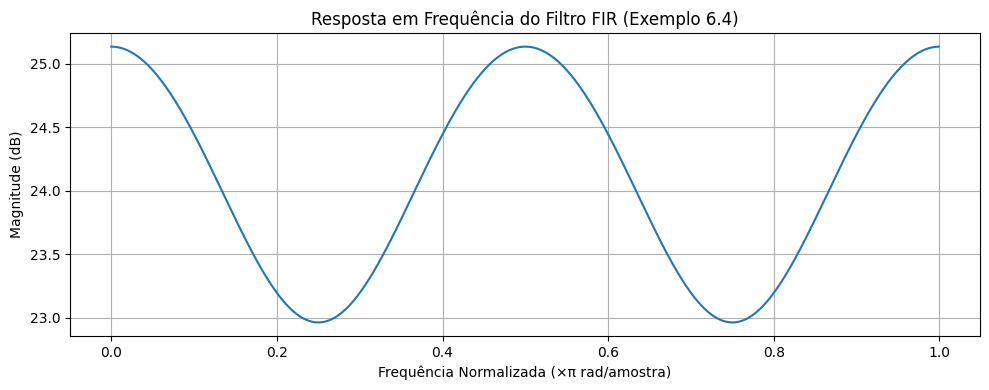

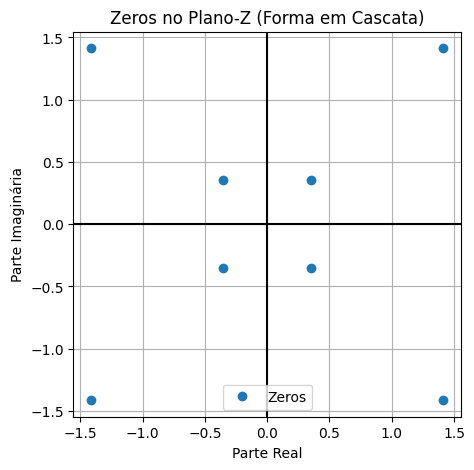

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, tf2zpk

# Coeficientes do filtro FIR
b = [1, 0, 0, 0, 16.0625, 0, 0, 0, 1]  # x(n), x(n-4), x(n-8)
a = [1]  # Filtro FIR: denominador é 1

# Resposta em frequência
w, h = freqz(b, a, worN=1024)
plt.figure(figsize=(10, 4))
plt.plot(w / np.pi, 20 * np.log10(np.abs(h)), label="|H(e^jω)| [dB]")
plt.title("Resposta em Frequência do Filtro FIR (Exemplo 6.4)")
plt.xlabel("Frequência Normalizada (×π rad/amostra)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Zeros e polos (para cascata)
z, p, k = tf2zpk(b, a)
plt.figure(figsize=(5, 5))
plt.plot(np.real(z), np.imag(z), 'o', label='Zeros')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Zeros no Plano-Z (Forma em Cascata)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


## EXEMPLO 6.6 – Forma de Amostragem em Frequência

Seja o filtro FIR com resposta ao impulso:

$$ h(n) = \frac{1}{9} \cdot \{1, 2, 3, 2, 1\} $$

Este filtro possui comprimento $M=5$, o que significa que ele é de ordem 4. Desejamos representar o filtro na forma de amostragem em frequência, baseada na DFT dos coeficientes $h(n)$.

A forma de amostragem em frequência reconstrói a função de sistema a partir de pares de seções paralelas de 2ª ordem (quando $M$ é ímpar) ou pares simétricos (quando $M$ é par), com base na DFT dos coeficientes.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Resposta ao impulso
h = np.array([1, 2, 3, 2, 1]) / 9
M = len(h)

# DFT da resposta ao impulso
H = np.fft.fft(h, M)
magH = np.abs(H)
phaH = np.angle(H)

# Exibir resultados (equivalente ao script MATLAB)
print("DFT H[k]:")
for k in range(M):
    print(f"H[{k}] = {H[k]:.4f} (|H| = {magH[k]:.4f}, ∠H = {phaH[k]:.4f} rad)")

# Estrutura baseada na função dir2fs (aproximação)
L = (M - 1) // 2  # M ímpar
k = np.arange(1, L + 1)

# Coeficientes do denominador A (seções de 2ª ordem)
A = np.ones((L, 3))
A[:, 1] = -2 * np.cos(2 * np.pi * k / M)

# Coeficientes do numerador B
B = np.zeros((L, 2))
B[:, 0] = np.cos(phaH[1:L + 1])
B[:, 1] = -np.cos(phaH[1:L + 1] - 2 * np.pi * k / M)

# Coeficientes de ganho C
C = np.concatenate(([2 * magH[1]], [2 * magH[2]], [np.real(H[0])]))

# Resultados
print("\nCoeficientes C (ganhos):")
print(np.round(C, 4))

print("\nCoeficientes B (numeradores):")
print(np.round(B, 4))

print("\nCoeficientes A (denominadores):")
print(np.round(A, 4))


DFT H[k]:
H[0] = 1.0000+0.0000j (|H| = 1.0000, ∠H = 0.0000 rad)
H[1] = -0.2353-0.1710j (|H| = 0.2909, ∠H = -2.5133 rad)
H[2] = 0.0131+0.0404j (|H| = 0.0424, ∠H = 1.2566 rad)
H[3] = 0.0131-0.0404j (|H| = 0.0424, ∠H = -1.2566 rad)
H[4] = -0.2353+0.1710j (|H| = 0.2909, ∠H = 2.5133 rad)

Coeficientes C (ganhos):
[0.5818 0.0849 1.    ]

Coeficientes B (numeradores):
[[-0.809  0.809]
 [ 0.309 -0.309]]

Coeficientes A (denominadores):
[[ 1.    -0.618  1.   ]
 [ 1.     1.618  1.   ]]


### 📘 6.4 – Estruturas de Filtros em Malha (*Lattice Filter Structures*)

A estrutura de filtro em malha, conhecida como **lattice filter**, é amplamente utilizada em aplicações de **processamento digital de fala** e na implementação de **filtros adaptativos**. Seu uso é preferido em várias situações por apresentar vantagens estruturais e numéricas, especialmente quando há necessidade de modelagem eficiente e estável de sistemas dinâmicos.

---

#### 🔧 Vantagens do Filtro em Malha

- **Estabilidade inerente**: estruturas em malha tendem a ser mais robustas frente a efeitos de quantização e erros numéricos, o que é desejável em sistemas em tempo real.
- **Modularidade**: os filtros em malha são compostos por estágios simples, permitindo fácil expansão e análise.
- **Aplicações em fala**: como em análise e síntese de voz, onde apenas um pequeno número de coeficientes pode representar uma grande quantidade de **formantes** (picos de ressonância), facilitando implementações em tempo real.

---

#### 🔀 Tipos de Estruturas

- **Lattice All-Zero (FIR)**  
  É a representação FIR da estrutura em malha, também chamada de **lattice filter**.  
  Ela possui somente **zeros** e é usada em casos onde a resposta ao impulso é de duração finita.

- **Lattice Ladder (IIR)**  
  Representa a forma **IIR** da estrutura, também conhecida como **lattice ladder**.  
  Esta forma contém **zeros e polos**, permitindo uma modelagem mais completa e flexível, especialmente em sinais com respostas impulsivas de duração infinita.

---

#### 📌 Resumo

| Tipo de Estrutura | Tipo de Filtro | Característica Principal                  |
|-------------------|----------------|-------------------------------------------|
| Lattice (All-Zero) | FIR            | Estrutura com resposta ao impulso finita  |
| Lattice Ladder     | IIR            | Estrutura com resposta ao impulso infinita|

---


### ✅ EXEMPLO 6.5 – Conversão para Estrutura em Malha (Lattice Filter)

Considere o filtro FIR descrito pela equação de diferenças:

$$
y(n) = 2x(n) + \frac{13}{12}x(n-1) + \frac{5}{4}x(n-2) + \frac{2}{3}x(n-3)
$$

Nosso objetivo é converter esse filtro para a **estrutura em malha all-zero**, ou seja, obter os **coeficientes de reflexão \( K \)** do filtro lattice.


In [1]:
import numpy as np

def dir2latc(b):
    """
    Conversão de Forma Direta FIR para Forma Lattice All-Zero
    K = dir2latc(b)
    K: coeficientes de reflexão (estrutura lattice)
    b: coeficientes FIR da forma direta (resposta ao impulso)
    """
    M = len(b)
    K = np.zeros(M)
    b1 = b[0]

    if b1 == 0:
        raise ValueError("b[0] é igual a zero")

    K[0] = b1
    A = b / b1

    for m in range(M-1, 0, -1):
        K[m] = A[m]
        J = np.flip(A)
        A = (A - K[m] * J) / (1 - K[m] * K[m])
        A = A[:m]

    return K

# Coeficientes do exemplo do livro
b = np.array([2, 13/12, 5/4, 2/3])
K = dir2latc(b)
print("Coeficientes da estrutura lattice (K):", K)


Coeficientes da estrutura lattice (K): [2.         0.25       0.5        0.33333333]


## Estrutura Lattice-Ladder

A estrutura *lattice-ladder* é uma representação comum para filtros IIR (Infinite Impulse Response), sendo útil principalmente em aplicações de processamento de fala e filtros adaptativos.

A forma *lattice* representa a parte recursiva (*denominador*) do filtro, enquanto a parte *ladder* representa a parte não recursiva (*numerador*). A função de sistema de um filtro IIR é dada por:

$$
H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_M z^{-M}}{a_0 + a_1 z^{-1} + \cdots + a_N z^{-N}}
$$

A conversão para a estrutura *lattice-ladder* envolve dois vetores de coeficientes:

- $K = [K_1, K_2, \ldots, K_{N-1}]$: coeficientes de reflexão da estrutura *lattice*
- $C = [C_0, C_1, \ldots, C_N]$: coeficientes da estrutura *ladder*

Esses coeficientes podem ser calculados a partir dos coeficientes $a$ (denominador) e $b$ (numerador) do filtro IIR.

---
### **Exemplo 6.8**

Considere o filtro IIR:

$$
H(z) = \frac{1 + 2z^{-1} + 2z^{-2} + z^{-3}}{1 + \frac{13}{24}z^{-1} + \frac{5}{8}z^{-2} + \frac{1}{3}z^{-3}}
$$

Seus coeficientes são:

- $b = [1, 2, 2, 1]$
- $a = [1, \frac{13}{24}, \frac{5}{8}, \frac{1}{3}]$

A estrutura *lattice-ladder* pode ser obtida a partir desses coeficientes.


In [2]:
import numpy as np

def dir2ladr(b, a):
    """
    Conversão de forma direta para estrutura lattice-ladder (IIR)
    b: coeficientes do numerador
    a: coeficientes do denominador
    Retorna:
        K: coeficientes da parte lattice
        C: coeficientes da parte ladder
    """
    b = np.array(b, dtype=float)
    a = np.array(a, dtype=float)
    a = a / a[0]
    b = b / a[0]

    M = len(b)
    N = len(a)

    if M > N:
        raise ValueError("O comprimento de b deve ser menor ou igual ao de a.")

    b = np.concatenate([b, np.zeros(N - M)])
    K = np.zeros(N - 1)
    C = b.copy()
    A = np.zeros((N - 1, N - 1))

    for m in range(N - 1, 0, -1):
        A[m - 1, :m] = -a[1:m + 1] * C[m]
        K[m - 1] = a[m]
        J = a[::-1]
        a = (a - K[m - 1] * J) / (1 - K[m - 1] ** 2)
        a = a[:m]
        if m < N - 1:
            C[m - 1] = b[m - 1] + np.sum(np.diag(A[m:N - 1, :N - m]))
        else:
            C[m - 1] = b[m - 1]

    return K, C

# Exemplo do livro
b = [1, 2, 2, 1]
a = [1, 13/24, 5/8, 1/3]

K, C = dir2ladr(b, a)

print("Coeficientes K (lattice):")
print(K)
print("\nCoeficientes C (ladder):")
print(C)


Coeficientes K (lattice):
[0.25       0.5        0.33333333]

Coeficientes C (ladder):
[-0.375       1.45833333  2.          1.        ]


### 6.5 Overview of Finite-Precision Numerical Effects

Até este ponto do livro, consideramos projetos de filtros digitais onde tanto os coeficientes quanto as operações (como adições e multiplicações) eram expressos usando números de precisão infinita. No entanto, quando implementamos sistemas de tempo discreto em hardware ou software, todos os parâmetros e operações aritméticas devem ser representados usando números de precisão finita, e seus efeitos são inevitáveis.

Vamos analisar um filtro digital implementado na estrutura Direct-Form II (Figura 6.24a do livro). Quando usamos representação de precisão finita, três aspectos principais afetam a qualidade da saída:

1.  **Quantização dos coeficientes do filtro**: Os coeficientes originais {aₖ, bₖ} são convertidos para suas representações de palavra finita {âₖ, b̂ₖ}
2.  **Quantização da sequência de entrada**: x(n) → x̂(n)
3.  **Operações aritméticas internas**: Todas as operações são convertidas para suas melhores representações possíveis dentro da precisão finita

Como resultado, a saída y(n) também se torna um valor quantizado ŷ(n), e obtemos uma nova realização do filtro Ĥ(z). Nosso objetivo é que este novo filtro Ĥ(z) e sua saída ŷ(n) sejam o mais próximo possível do filtro original H(z) e da saída original y(n).

### Desafios na Análise
A operação de quantização é não-linear, o que torna a análise completa considerando todos os três efeitos simultaneamente extremamente complexa. Por isso, adotamos uma abordagem mais prática:

$$ \text{Análise completa} \rightarrow \text{Difícil} $$
$$ \text{Análise isolada de cada efeito} \rightarrow \text{Interpretável} $$


## 6.6 Representação de Números em Sistemas Digitais

## Fundamentos da Representação Numérica
Em computadores, números (reais, complexos, inteiros ou fracionários) são representados usando dígitos binários (bits - 0 ou 1). A aritmética de palavra finita pode ser implementada de duas formas principais:

1. **Aritmética de Ponto Fixo**  
   - Mais simples de implementar  
   - Alcance dinâmico fixo (limitações com números muito grandes ou muito pequenos)  
   - Precisão absoluta constante  

2. **Aritmética de Ponto Flutuante**  
   - Alcance dinâmico amplo  
   - Precisão relativa (varia com a magnitude do número)  
   - Implementação e análise mais complexas  

## Representação de Números Negativos
Para números negativos, existem três formatos principais:

### 1. Formato Sinal-Magnitude
- Bit mais significativo (MSB) indica o sinal (0 = positivo, 1 = negativo)  
- Magnitude representada pelos bits restantes  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 10000101$$  

### 2. Formato Complemento de Um
- Números negativos são obtidos invertendo todos os bits do positivo correspondente  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 11111010$$  

### 3. Formato Complemento de Dois
- Números negativos são obtidos invertendo os bits e somando 1  
- Elimina a representação dupla do zero  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 11111011$$  

## Representação de Inteiros com Sinal
Um número inteiro $x$ em representação binária de $B$ bits é dado por:

$$x \equiv b_{B-1}b_{B-2}...b_0 = b_{B-1} \times 2^{B-1} + b_{B-2} \times 2^{B-2} + \cdots + b_0 \times 2^0$$

Onde cada $b_i$ representa 0 ou 1. Esta fórmula é válida para qualquer sistema numérico (hexadecimal, octal, etc.).

## Extensão para Números Fracionários
Os conceitos acima são estendidos para:
- **Ponto Fixo Fracionário**: Mesmo formato, mas com bits representando potências negativas de 2  
- **Ponto Flutuante**: Representação por mantissa e expoente (maior alcance dinâmico)

In [3]:
import numpy as np

def ones_complement(x, B):
    """
    Converte números inteiros no formato sinal-magnitude para complemento de um

    Parâmetros:
        x: array ou valor inteiro entre -2^(B-1) < x < 2^(B-1) (sinal-magnitude)
        B: número de bits

    Retorna:
        y: inteiros entre 0 <= y <= 2^B-1 (complemento de um)
    """
    x = np.asarray(x)
    if np.any((x <= -2**(B-1)) | (x >= 2**(B-1))):
        raise ValueError('Números devem satisfazer -2^(B-1) < x < 2^(B-1)')

    s = np.sign(x)  # sinal de x (-1 se x<0, 0 se x=0, 1 se x>0)
    sb = (s < 0).astype(int)  # bit de sinal (0 se x>=0, 1 se x<0)

    # Máscara para garantir que estamos trabalhando com B bits
    mask = (1 << B) - 1
    y = (1 - sb) * x + sb * ((1 << B) - 1 - np.abs(x))

    return y & mask  # Aplicar máscara para garantir B bits

# Exemplo equivalente ao Exemplo 6.11
x = np.arange(-7, 8)  # Array de -7 a 7
y = ones_complement(x, 4)

print("Entrada (sinal-magnitude):", x)
print("Saída (complemento de 1):", y)

Entrada (sinal-magnitude): [-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
Saída (complemento de 1): [ 8  9 10 11 12 13 14  0  1  2  3  4  5  6  7]


In [5]:
import numpy as np

def twos_complement(x, b):
    """
    Converte números inteiros no formato sinal-magnitude para complemento de dois

    Parâmetros:
        x: array ou valor inteiro entre -2^(b-1) <= x < 2^(b-1) (sinal-magnitude)
        b: número de bits

    Retorna:
        y: inteiros entre 0 <= y <= 2^b-1 (complemento de dois)
    """
    x = np.asarray(x)
    if np.any((x < -2**(b-1))) | np.any((x >= 2**(b-1))):
        raise ValueError(f'Números devem satisfazer -2^{b-1} <= x < 2^{b-1}')

    s = np.sign(x)  # sinal de x (-1 se x<0, 0 se x=0, 1 se x>0)
    sb = (s < 0).astype(int)  # bit de sinal (0 se x>=0, 1 se x<0)

    mask = (1 << b) - 1  # Máscara para garantir b bits
    y = (1 - sb) * x + sb * ((1 << b) + x)

    return y & mask

# Exemplo equivalente ao Exemplo 6.12
x = np.arange(-8, 8)  # Array de -8 a 7
y = twos_complement(x, 4)

print("Entrada (sinal-magnitude):", x)
print("Saída (complemento de 2):", y)

# Versão binária formatada (opcional)
print("\nRepresentação binária (4 bits):")
for num in y:
    print(f"{num:04b}", end=' ')

Entrada (sinal-magnitude): [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
Saída (complemento de 2): [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]

Representação binária (4 bits):
1000 1001 1010 1011 1100 1101 1110 1111 0000 0001 0010 0011 0100 0101 0110 0111 

# Aritmética de Ponto Fixo Geral

## Representação de Números Reais em Ponto Fixo

A representação de ponto fixo estende o conceito de inteiros para números reais (inteiros e fracionários). Um número real de precisão infinita $$x$$ é aproximado por um número binário $$\hat{x}$$ com o seguinte formato:

$$
\hat{x} = \underbrace{\pm}_{\text{Bit de sinal}} \underbrace{xx\cdots x}_{L \text{ bits inteiros}} \underbrace{\blacktriangle xx\cdots x}_{B \text{ bits fracionários}}
$$

### Componentes da Representação:
1. **Bit de sinal** (1 bit):
   - `0` para números positivos  
   - `1` para números negativos  

2. **Parte inteira** (L bits):
   - Representa a parte inteira do número  
   - Equivalente à representação binária padrão  

3. **Parte fracionária** (B bits):
   - Representa potências negativas de 2  
   - $$\blacktriangle$$ indica a posição do ponto binário  

### Comprimento Total da Palavra:
- **Total de bits**: $$L + B + 1$$ (1 bit de sinal + L bits inteiros + B bits fracionários)

### Exemplo Numérico:
Considere a representação $$L=3$$, $$B=2$$ (total 6 bits):

- Número $$+5.75$$ em binário:
  $$
  \underbrace{0}_{\text{sinal}} \underbrace{101}_{\text{parte inteira (5)}} \underbrace{\blacktriangle 11}_{\text{parte fracionária (0.75)}}
  $$
  - Parte inteira: $$1 \times 2^2 + 0 \times 2^1 + 1 \times 2^0 = 5$$
  - Parte fracionária: $$1 \times 2^{-1} + 1 \times 2^{-2} = 0.75$$

## Características Importantes:
1. **Faixa Dinâmica Limitada**:
   - Máximo valor absoluto representável: $$2^L - 2^{-B}$$
   - Mínimo valor absoluto: $$2^{-B}$$

2. **Precisão Fixa**:
   - Resolução constante: $$2^{-B}$$  
   - Erro de quantização máximo: $$\frac{2^{-B}}{2}$$

3. **Eficiência Computacional**:
   - Operações aritméticas mais rápidas que em ponto flutuante  
   - Ideal para sistemas embarcados com recursos limitados

# Aritmética de Ponto Flutuante (6.6.3)

## Motivação e Conceito Básico
A representação em **ponto flutuante** resolve o problema de alcance dinâmico em aplicações que envolvem números com magnitudes extremamente diferentes (ex.: massa do Sol ≈ 2×10³⁰ kg vs. massa do elétron ≈ 9×10⁻³¹ kg).

**Princípio fundamental**:
$$ x = \pm M \times 10^{\pm E} $$
- **M (mantissa)**: Dígitos significativos (precisão)
- **E (expoente)**: Ordem de magnitude (alcance)

## Formato Normalizado
Para evitar ambiguidades, usa-se **forma normalizada**:
- Apenas **um dígito não-zero** à esquerda do ponto decimal  
Exemplo:
$$ 1234 = 1.234 \times 10^3 \quad \text{(única representação normalizada)} $$

## Representação Binária (IEEE-like)
Para números binários, o formato segue uma estrutura similar mas com particularidades:

$$
\hat{x} = \underbrace{\pm}_{\text{Bit de sinal}} \underbrace{1.xx\cdots x}_{B \text{ bits da mantissa}} \times 2^{\underbrace{xx\cdots x}_{L \text{ bits do expoente}}}
$$

### Características Chave:
1. **Mantissa Normalizada**:
   - Sempre inicia com `1` após o ponto binário (implícito em alguns padrões)
   - Faixa: $$ \frac{1}{2} \leq M < 1 $$

2. **Expoente em Excesso** (Excess-2<sup>L-1</sup>):
   - Permite expoentes negativos sem bit de sinal separado
   - Exemplo: 8 bits → excesso de 127 (Excesso-127)


3. **Equivalente Decimal**:
$$ \hat{x} = \pm M \times 2^E $$

## Vantagens sobre Ponto Fixo
| Característica       | Ponto Fixo          | Ponto Flutuante       |
|----------------------|---------------------|-----------------------|
| **Alcance Dinâmico** | Limitado            | Extremamente amplo    |
| **Precisão**         | Uniforme            | Relativa à magnitude  |
| **Overflow**         | Frequente em adições| Raro                  |

## Exemplo Numérico (Binário)
Considere um formato hipotético com:
- **1 bit de sinal**
- **4 bits de expoente** (Excesso-8)
- **3 bits de mantissa**

Representação do número $$ x = 1.101 \times 2^{5} $$:
- **Bit de sinal**: `0` (positivo)
- **Expoente**: `5 + 8 = 13` → `1101` (binário)
- **Mantissa**: `101` (parte fracionária)
- **Bit pattern final**: `0 1101 101`

## Limitações
1. **Precisão Variável**: Erros relativos maiores para números muito pequenos
2. **Complexidade**: Operações aritméticas mais custosas que em ponto fixo
3. **Padronização**: Necessidade de conformidade com IEEE 754 para portabilidade

# 6.7 O Processo de Quantização e Caracterização de Erros

## Fundamentos da Quantização
A quantização é o processo de mapear um valor contínuo (ou de alta precisão) para um conjunto discreto de níveis. Em sistemas digitais, isso ocorre em três cenários principais:

1. **Quantização de Sinais**: Conversão A/D de x(n) para x̂(n)
2. **Quantização de Coeficientes**: Implementação de {aₖ,bₖ} como {âₖ,b̂ₖ}
3. **Quantização Aritmética**: Limitação em operações (multiplicações, adições)

## Modelo Matemático da Quantização
Para um número real x, sua versão quantizada Q(x) é dada por:

$$
Q(x) = x + e_q
$$

Onde:
- $$e_q$$ é o **erro de quantização**
- Assume-se geralmente que $$e_q$$ é:
  - Aleatório
  - Uniformemente distribuído
  - Não correlacionado com x

## Tipos de Quantização
### 1. Truncamento (Floor)
- Descarta bits menos significativos
- Viés negativo: $$ -\Delta < e_q \leq 0 $$
- Equação: $$ Q_T(x) = \Delta \cdot \lfloor x/\Delta \rfloor $$

### 2. Arredondamento (Round)
- Nível mais próximo
- Simétrico: $$ -\Delta/2 \leq e_q \leq \Delta/2 $$
- Equação: $$ Q_R(x) = \Delta \cdot \lfloor x/\Delta + 0.5 \rfloor $$

*(Onde Δ = 2⁻ᴮ para B bits fracionários)*

## Análise Estatística do Erro
| Parâmetro       | Truncamento | Arredondamento |
|----------------|------------|---------------|
| Média (μ)      | -Δ/2       | 0             |
| Variância (σ²) | Δ²/12      | Δ²/12         |

## Efeitos na Implementação de Filtros
### 1. Ruído de Quantização
- Modelado como aditivo: $$ y(n) = y_{ideal}(n) + e(n) $$
- Potência do ruído: $$ \sigma_e^2 = \frac{2^{-2B}}{12} $$

### 2. Propagação em Filtros IIR
A saída do ruído para um filtro com função de transferência H(z):

$$
\sigma_y^2 = \sigma_e^2 \cdot \frac{1}{2\pi j} \oint H(z)H(z^{-1})z^{-1}dz
$$


# ## Exemplo 6.20: Caracterização do Erro de Truncamento
 **Objetivo**: Verificar as relações de erro para truncamento com B=2 bits no intervalo -1 < x < 1

### Teoria Básica
Para truncamento com B bits fracionários:
- **Resolução (Δ)**: $$ \Delta = 2^{-B} = 0.25 $$ (para B=2)
- **Erro de truncamento**: $$ -\Delta < e_T \leq 0 $$

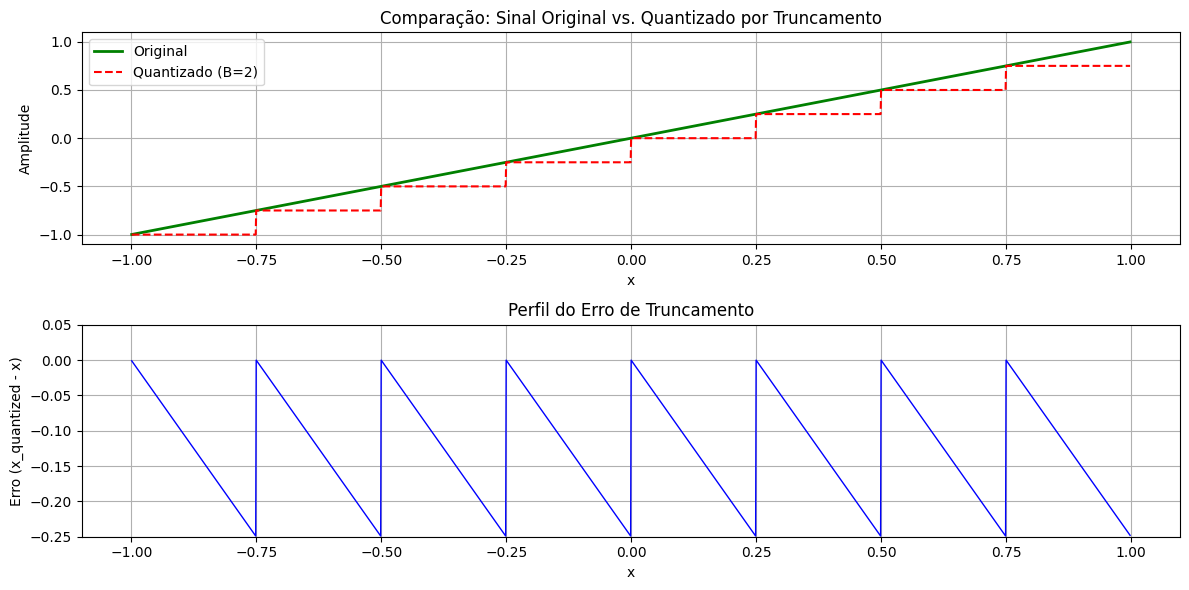

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração do problema
B = 2  # Número de bits fracionários
delta = 2**(-B)  # Resolução = 0.25

# Geração do sinal de entrada (evitando os extremos -1 e 1)
x = np.arange(-1 + 2**(-10), 1 - 2**(-10), 2**(-10))

# Quantização por truncamento (equivalente ao 'fix' do MATLAB)
x_quantized = np.floor(x * 2**B) / 2**B

# Cálculo do erro
error = x_quantized - x

# Gráfico 1: Sinal original vs. quantizado
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, x, 'g-', linewidth=2, label='Original')
plt.plot(x, x_quantized, 'r--', linewidth=1.5, label='Quantizado (B=2)')
plt.title('Comparação: Sinal Original vs. Quantizado por Truncamento')
plt.xlabel('x'); plt.ylabel('Amplitude')
plt.legend(); plt.grid(True)

# Gráfico 2: Erro de quantização
plt.subplot(2, 1, 2)
plt.plot(x, error, 'b', linewidth=1)
plt.title('Perfil do Erro de Truncamento')
plt.xlabel('x'); plt.ylabel('Erro (x_quantized - x)')
plt.ylim([-delta, 0.05])  # Mostrando o limite teórico
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
print(f"Resolução teórica (Δ): {delta:.4f}")
print(f"Média do erro: {np.mean(error):.6f} (Teórica: -Δ/2 = {-delta/2:.4f})")
print(f"Variância do erro: {np.var(error):.6f} (Teórica: Δ²/12 = {(delta**2)/12:.6f})")
print(f"Erro mínimo: {np.min(error):.6f}")
print(f"Erro máximo: {np.max(error):.6f}")

Resolução teórica (Δ): 0.2500
Média do erro: -0.124512 (Teórica: -Δ/2 = -0.1250)
Variância do erro: 0.005198 (Teórica: Δ²/12 = 0.005208)
Erro mínimo: -0.249023
Erro máximo: 0.000000


# 6.8 Quantização de Coeficientes de Filtros

##  Filtros IIR

### Impacto Fundamental
A quantização de coeficientes em filtros IIR pode alterar radicalmente suas propriedades devido à natureza recursiva. Os principais efeitos incluem:

1. **Deslocamento de Polos**:
   - Pequenas variações nos coeficientes podem mover polos para fora do círculo unitário, tornando o sistema instável
   - Sensibilidade especialmente crítica em filtros de alta ordem

2. **Mudança na Resposta Temporal**:
   - Constantes de tempo alteradas
   - Possível introdução de oscilações não previstas

3. **Propagação de Erros**:
   - Erros nos coeficientes se propagam através das seções recursivas
   - Efeito cumulativo em estruturas em cascata

##  Efeito nas Localizações de Polos e Zeros

### Mecanismo de Perturbação
Para um filtro com função de transferência:

$$
H(z) = \frac{\sum_{k=0}^M b_k z^{-k}}{1 + \sum_{k=1}^N a_k z^{-k}}
$$

A quantização altera:
- **Posições de zeros** (menos crítico em IIR)
- **Posições de polos** (altamente sensível)

### Teoria da Sensibilidade
A sensibilidade da posição de um polo $p_i$ em relação ao coeficiente $a_k$ é dada por:

$$
\frac{\partial p_i}{\partial a_k} = -\frac{p_i^{N-k}}{\prod_{l \neq i}(p_i - p_l)}
$$

Implicações:
1. **Polos Agrupados** → Maior sensibilidade
2. **Ordem Elevada** → Efeitos mais pronunciados
3. **Polos Próximos ao Círculo Unitário** → Risco de instabilidade

### Caso Prático Típico
- Filtro elíptico de 8ª ordem pode se tornar instável com 12 bits
- Filtro Butterworth mostra menor sensibilidade que Chebyshev

##  Efeitos na Resposta em Frequência

### Alterações Qualitativas
1. **Banda de Passagem**:
   - Variação no ripple
   - Mudança na frequência de corte

2. **Banda de Rejeição**:
   - Redução da atenuação
   - Aparecimento de "lóbulos" extras

3. **Transição**:
   - Alargamento da banda de transição
   - Inclinação alterada

### Métricas Quantitativas
- **Erro Relativo na Magnitude**:

  $$
  \delta_H(\omega) = \frac{|H_q(e^{j\omega}) - H(e^{j\omega})|}{|H(e^{j\omega})|}
  $$

- **Desvio de Fase**:
  - Crítico em aplicações de processamento de sinais temporais

### Fatores de Influência
| Fator | Impacto na Resposta |
|-------|---------------------|
| Número de bits | Melhoria logarítmica com aumento de bits |
| Tipo de Filtro | Elíptico > Chebyshev > Butterworth |
| Estrutura | Cascata > Paralela > Direta |



## Exemplo 6.25: Ressonador Digital

### Sistema Original
- **Coeficientes**:
  $$ a_1 = -0.9, \quad a_2 = 0.81 $$
- **Polos**:
  $$ p_{1,2} = 0.9e^{\pm j\pi/3} $$ (raio = 0.9, ângulo = ±60°)

### Processo de Quantização
A função `QCoeff` realiza:
1. Determinação automática de bits inteiros (L) e fracionários (B)
2. Quantização por arredondamento para N bits totais
3. Preservação do sinal original

In [11]:
import numpy as np

def q_coeff(x, N):
    xm = np.max(np.abs(x)) # Encontra o valor absoluto máximo para determinar L
    if xm == 0: # Lidar com o caso de input zero
        L = 0
    else:
        L = np.maximum(0, np.floor(np.log2(xm) + 1)).astype(int)


    if N <= L:
        raise ValueError(f'O número total de bits N ({N}) deve ser maior que o número de bits inteiros necessários L ({L}). Considere aumentar N.')

    B = N - L - 1 # N = 1 (sinal) + L (inteiro) + B (fracionário)


    scaled_x = x * (2**B)

    # Arredondar para o inteiro mais próximo
    rounded_x = np.round(scaled_x)

    # Escalar de volta dividindo por 2^B
    y = rounded_x / (2**B)

    return y, L, B

# Coeficientes originais
a1, a2 = -0.9, 0.81

N_bits = 4
try:
    a_quant, L, B = q_coeff(np.array([a1, a2]), N_bits)
    print(f'Coeficientes originais: [{a1}, {a2}]')
    print(f'Coeficientes quantizados ({N_bits} bits): {a_quant}')
    print(f'Bits inteiros (L): {L}, Bits fracionários (B): {B}')

    # Cálculo dos polos
    # Originais
    r = 0.9
    theta = np.pi/3
    p1 = r * np.exp(1j * theta)

    if a_quant[1] < 0:
        print("Erro: Coeficiente a_quant[1] é negativo, polos complexos não podem ser calculados desta forma.")
    else:
        r_hat = np.sqrt(a_quant[1])
        # Certifique-se que o argumento de arccos está entre -1 e 1
        arg_theta_hat = -a_quant[0]/(2*r_hat)
        if np.abs(arg_theta_hat) > 1:
             print(f"Erro: Argumento de arccos fora do intervalo [-1, 1]: {arg_theta_hat:.4f}")
        else:
            theta_hat = np.arccos(arg_theta_hat)
            p1_hat = r_hat * np.exp(1j * theta_hat)

            # Variação na posição dos polos
            delta_p = np.abs(p1 - p1_hat)
            print(f'Polo original: {p1:.4f}')
            print(f'Polo quantizado: {p1_hat:.4f}')
            print(f'Deslocamento do polo: {delta_p:.4f}')

except ValueError as e:
    print(f"Erro ao quantizar: {e}")

Coeficientes originais: [-0.9, 0.81]
Coeficientes quantizados (4 bits): [-0.875  0.75 ]
Bits inteiros (L): 0, Bits fracionários (B): 3
Polo original: 0.4500+0.7794j
Polo quantizado: 0.4375+0.7474j
Deslocamento do polo: 0.0344
